# Horizon holes filling 填充层位空洞

**Author: M. Ravasi, KAUST**

Welcome to the **Matrix-free inverse problems with PyLops** tutorial!

欢迎来到 **PyLops 无矩阵逆问题** 教程！

The aim of this tutorial is to fill holes in seismic horizons (also known in the computer vision community as **inpainting**). 

本教程的目的是填充地震层位中的空洞（在计算机视觉领域也称为 **修复 (inpainting)**）。

This notebook uses an horizon from Matt's paper [M. Hall (2007). Smooth operator: Smoothing seismic interpretations and attributes. The Leading Edge 26, p16–20](https://library.seg.org/doi/10.1190/1.2431821) and it is heavily inspired by [S. Fomel DWT jupyter notebook](https://github.com/sfomel/ipython/blob/master/DWT.ipynb) As a by-product you will learn to:

本笔记本使用了 Matt 的论文 [M. Hall (2007). Smooth operator: Smoothing seismic interpretations and attributes. The Leading Edge 26, p16–20](https://library.seg.org/doi/10.1190/1.2431821) 中的层位数据，并深受 [S. Fomel DWT jupyter notebook](https://github.com/sfomel/ipython/blob/master/DWT.ipynb) 的启发。作为副产品，您将学习到：

- Familiarize with the `pylops.signalprocessing` submodule, and more specifically with the 2D-FFT (``FFT2D``) and Wavelet transform (``DWT``);
- Learn how to use sparse solvers within the `pylops.optimization.sparsity` submodule, and more specifically the FISTA solver.

- 熟悉 `pylops.signalprocessing` 子模块，特别是二维 FFT (``FFT2D``) 和小波变换 (``DWT``)；
- 学习如何在 `pylops.optimization.sparsity` 子模块中使用稀疏求解器，特别是 FISTA 求解器。

From a mathematical point of view we write the impainting problem as follows:

从数学角度来看，我们将修复问题写成如下形式：

$$
J = arg min_{\mathbf{p}} ||\mathbf{d} - \mathbf{M} \mathbf{P} \mathbf{p}||_2 + \epsilon ||\mathbf{p}||_1
$$

where $\mathbf{M}$ is a masking operator, $\mathbf{P}$ is a sparsyfing transform, $\mathbf{d}$ is the horizon with holes, and $\mathbf{m}=\mathbf{P}\mathbf{p}$ is the filled horizon we wish to obtain.

其中 $\mathbf{M}$ 是掩膜算子，$\mathbf{P}$ 是稀疏变换，$\mathbf{d}$ 是带有空洞的层位，$\mathbf{m}=\mathbf{P}\mathbf{p}$ 是我们希望获得的填充后的层位。

Let's first import the libraries we need in this tutorial

首先让我们导入本教程所需的库。

In [2]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops scooby

In [3]:
%matplotlib inline


import os

import matplotlib.pyplot as plt
import numpy as np
import scooby
from pylops.basicoperators import Diagonal
from pylops.optimization.sparsity import FISTA
from pylops.signalprocessing import DWT, DWT2D, FFT2D
from pylops.utils.tapers import taper2d

# 修复 OMP: Error #15 冲突
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Data loading 数据加载

Let's start by loading a seismic horizon 让我们从加载一个地震层位开始。

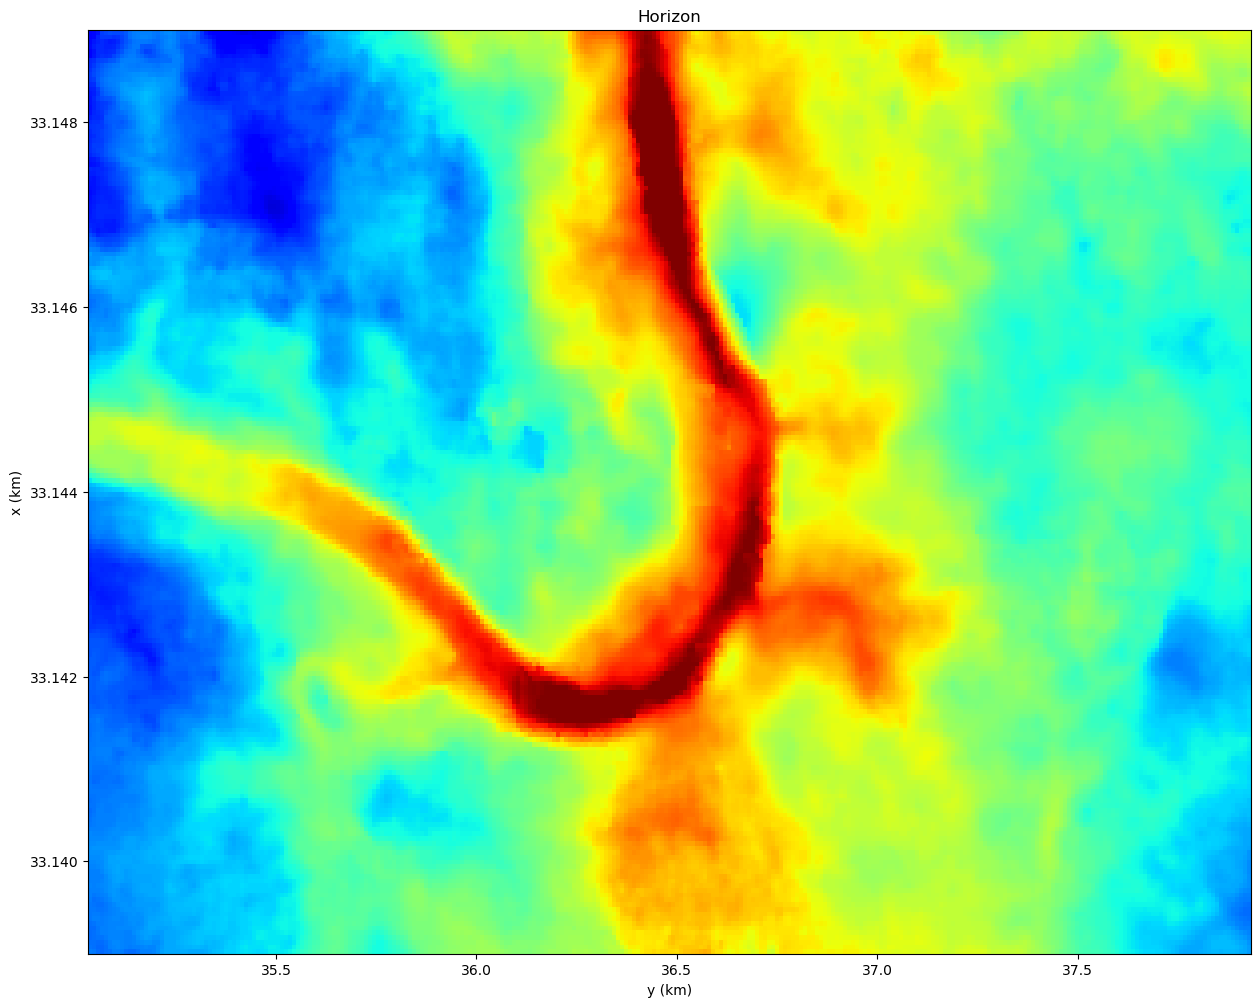

In [4]:
# You can download this horizon using Madagascar's command: Fetch('horizon.asc','hall')
# And it is now also provided in our data folder.
f = np.loadtxt('data/horizon.asc')
ig = f[:, -1]-65
ig = ig.reshape(291, 196).T
nyorig, nxorig = ig.shape
y = 33.139 + np.arange(nyorig) * 0.01
x = 35.031 + np.arange(nxorig) * 0.01

# We apply some tapering on the edges
#tap = taper2d(nxorig, nyorig, (25, 25))
#ig = ig * tap

# Pad to closest multiple of 2 (for DWT)
ig = np.pad(ig, ((0, 256-nyorig), (0, 512-nxorig)))
ny, nx = ig.shape

plt.figure(figsize=(15, 12))
plt.imshow(ig[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
           extent=(x[0], x[-1], y[0], y[1]), origin='lower')
plt.xlabel('y (km)')
plt.ylabel('x (km)')
plt.title('Horizon')
plt.axis('tight');

Let's now create some holes in the horizon.

现在让我们在层位中创建一些空洞。

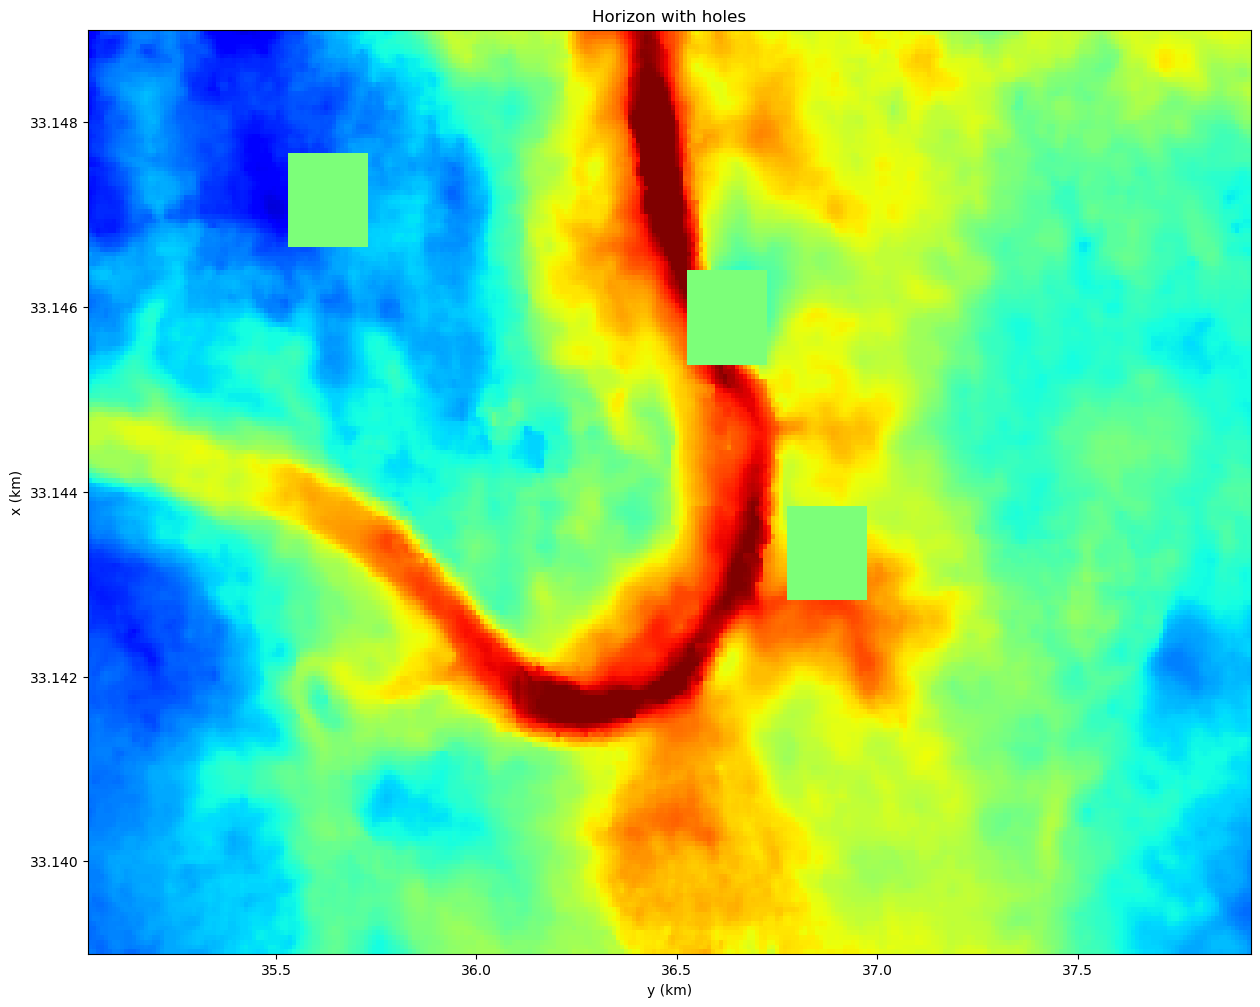

In [5]:
mask = np.ones_like(ig)
mask[125:145, 150:170] = 0
mask[150:170, 50:70] = 0
mask[75:95, 175:195] = 0
igholes = ig * mask

plt.figure(figsize=(15, 12))
plt.imshow(igholes[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
           extent=(x[0], x[-1], y[0], y[1]), origin='lower')
plt.xlabel('y (km)')
plt.ylabel('x (km)')
plt.title('Horizon with holes')
plt.axis('tight');

## Reconstruction with DWT 使用 DWT 进行重建

First of all we need to create the sparsyfing operator.

首先，我们需要创建稀疏算子。

c:\Users\WangQinZhuo\miniconda3\envs\transform2021_devito\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


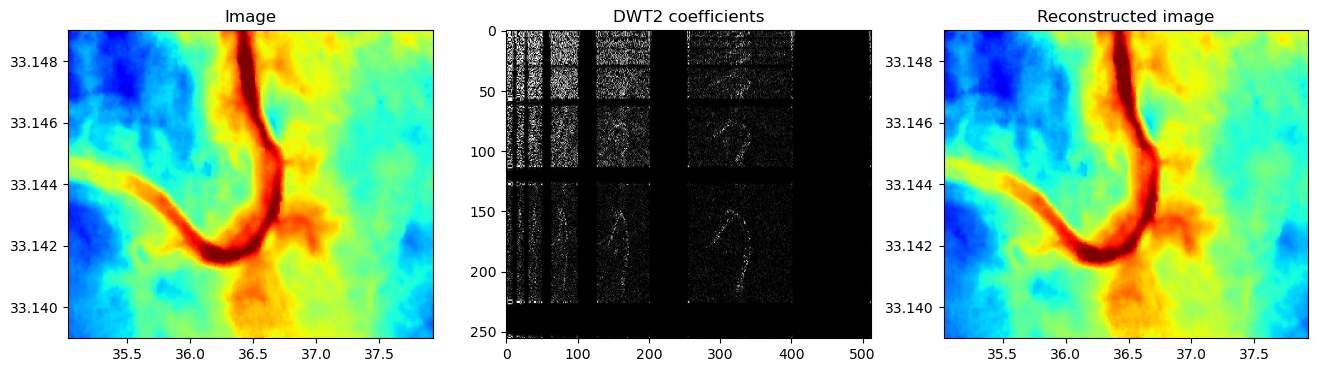

In [6]:
wavkind = 'sym9'

# Cascaded DWT
Wopy, Wopx = DWT((ny,nx), 1, wavelet=wavkind, level=5), DWT((ny,nx), 0, wavelet=wavkind, level=5)
Wop = Wopy*Wopx
dimswav = Wopy.dimsd

# DWT2D
#Wop = DWT2D((ny, nx), wavelet=wavkind, level=5)
#dimswav = Wop.dimsd

ig_wav = Wop * ig.ravel()  # type: ignore
iginv = Wop.H * ig_wav
iginv = iginv.reshape(ny, nx)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(ig[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[0].set_title('Image')
axs[0].axis('tight')
axs[1].imshow(ig_wav.reshape(dimswav), cmap='gray', vmin=0, vmax=5e-1)
axs[1].set_title('DWT2 coefficients')
axs[1].axis('tight')
axs[2].imshow(iginv[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[2].set_title('Reconstructed image')
axs[2].axis('tight');

Let's now solve the inverse problem.

现在让我们求解逆问题。

FISTA (soft-percentile thresholding)
--------------------------------------------------------------------------------
The Operator Op has 131072 rows and 131072 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 1.000000e+00	perc = 10.0
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1      -2.1355e+02         3.678e+02   2.794e+03   1.180e+03
     2      -2.1355e+02         3.622e+02   2.783e+03   3.994e+00
     3      -2.1355e+02         3.575e+02   2.773e+03   4.574e+00
     4      -2.1355e+02         3.551e+02   2.763e+03   5.078e+00
     5      -2.1356e+02         3.527e+02   2.753e+03   5.554e+00
     6      -2.1356e+02         3.509e+02   2.743e+03   5.982e+00
     7      -2.1356e+02         3.492e+02   2.733e+03   6.428e+00
     8      -2.1356e+02         3.468e+02   2.723e+03   6.798e+00
     9      -2.1356e+02         3.443e+02   2.713e+03   7.095e+00
    10     

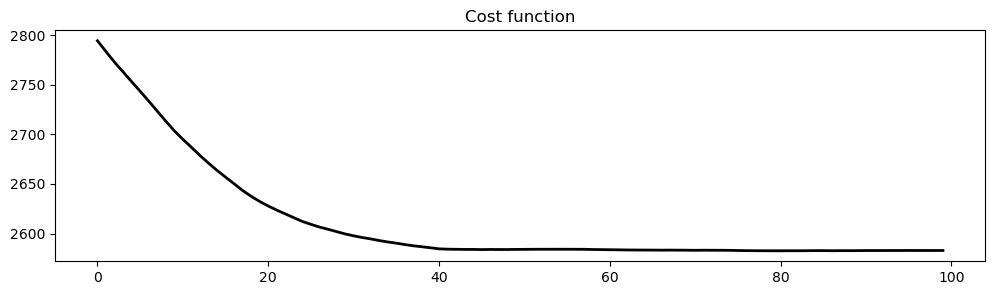

In [8]:
Op = Diagonal(mask.ravel())

igdata = Op * ig.ravel()  # type: ignore

# 修改：先实例化 FISTA 类，传入算子
solver = FISTA(Op * Wop.H)  # type: ignore

# 修改：调用 solve 方法传入数据和其他参数
# 注意：移除了 returninfo=True，因为 solve 默认返回 (x, niter, cost)
igfilled_wav, niter, cost = solver.solve(igdata, niter=100,
                                  #threshkind='soft', eps=1e1,
                                  threshkind='soft-percentile', perc=10,
                                  show=True)

igfilled = np.real((Wop.H * igfilled_wav).reshape(ny, nx))

plt.figure(figsize=(12, 3))
plt.plot(cost, 'k', lw=2)
plt.title('Cost function');

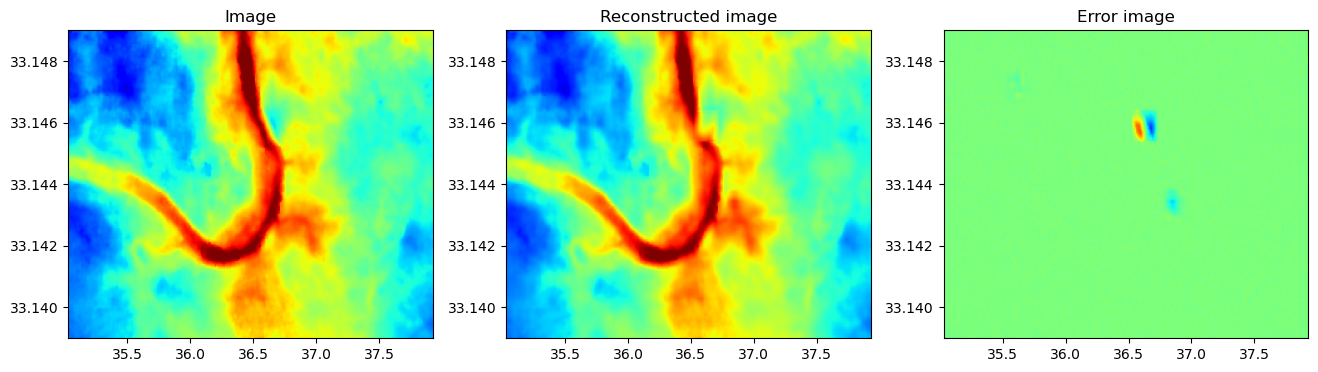

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(ig[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[0].set_title('Image')
axs[0].axis('tight')
axs[1].imshow(igfilled[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[1].set_title('Reconstructed image')
axs[1].axis('tight');
axs[2].imshow(ig[:nyorig, :nxorig]-igfilled[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[2].set_title('Error image')
axs[2].axis('tight');

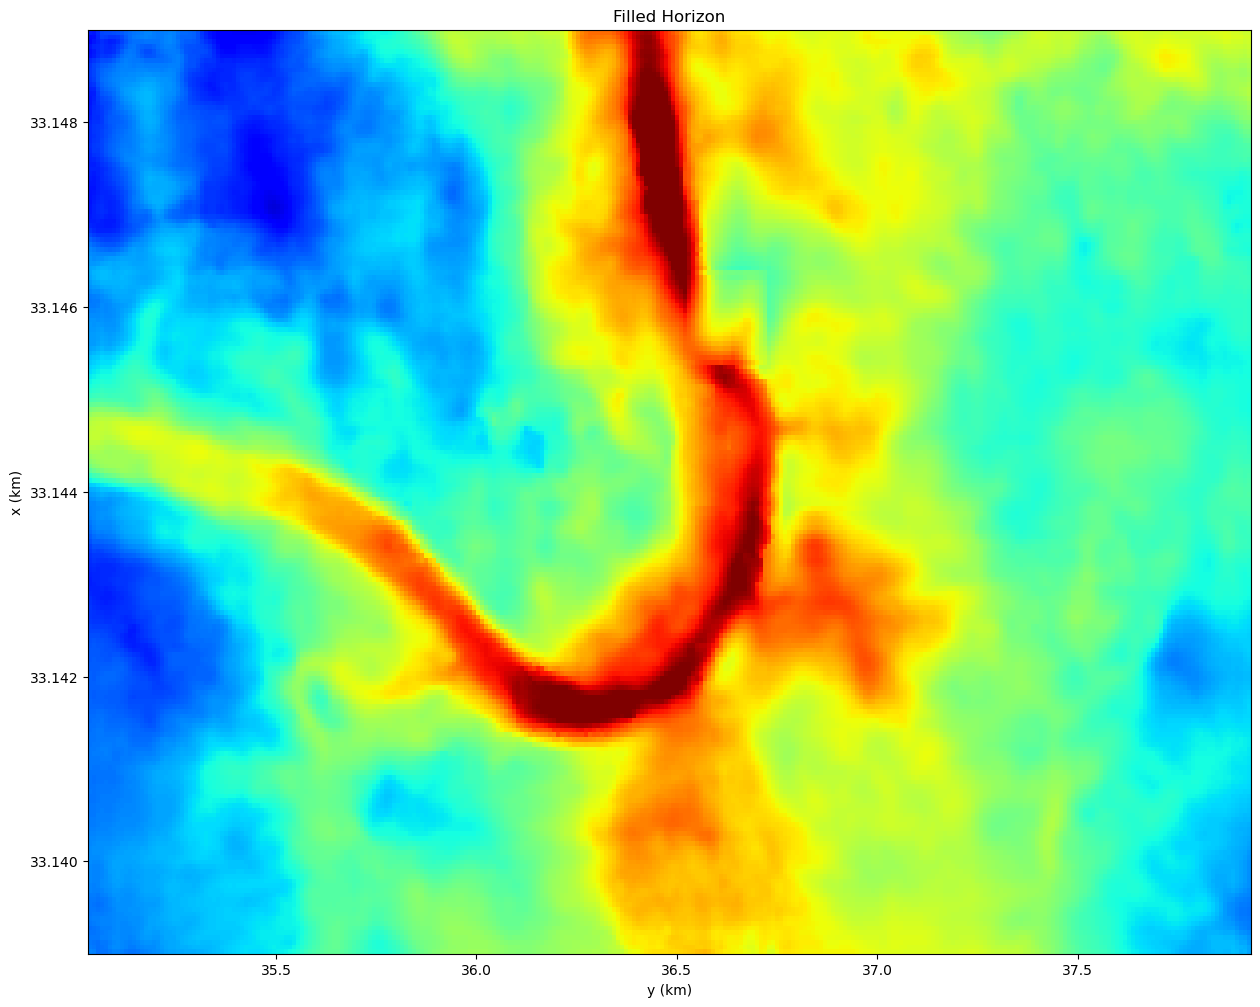

In [10]:
plt.figure(figsize=(15, 12))
plt.imshow(igfilled[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
           extent=(x[0], x[-1], y[0], y[1]), origin='lower')
plt.xlabel('y (km)')
plt.ylabel('x (km)')
plt.title('Filled Horizon')
plt.axis('tight');

At this point you may wonder if the DWT is the best sparsifying transform for this data. 

此时您可能会想，DWT 是否是该数据的最佳稀疏变换。

I encourage you to experiment with more transforms, for example:

我鼓励您尝试更多的变换，例如：

- ``FFT2D`` (as shown below);
- ``Curvelet`` transform (see [curvelops](https://github.com/PyLops/curvelops) for a PyLops wrapper);
- Other transforms such as the Shearlet transform (you try to wrap [pyshearlab](http://na.math.uni-goettingen.de/pyshearlab/) into PyLops).

- ``FFT2D``（如下所示）；
- ``Curvelet`` 变换（参见 [curvelops](https://github.com/PyLops/curvelops) 获取 PyLops 封装）；
- 其他变换，如 Shearlet 变换（您可以尝试将 [pyshearlab](http://na.math.uni-goettingen.de/pyshearlab/) 封装到 PyLops 中）。

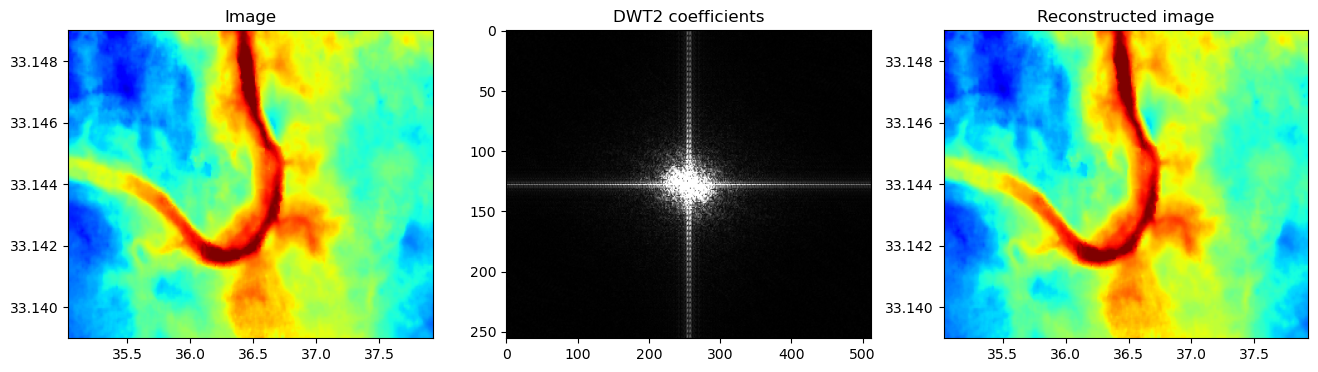

In [11]:
Wop = FFT2D((ny, nx))
ig_wav = Wop * ig.ravel()  # type: ignore
igholes_wav = Wop * igholes.ravel()  # type: ignore
iginv = Wop.H * ig_wav
iginv = np.real(iginv).reshape(ny, nx)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(ig[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[0].set_title('Image')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(np.abs(np.reshape(ig_wav, (ny,nx)))),
              cmap='gray', vmin=0, vmax=5)
axs[1].set_title('DWT2 coefficients')
axs[1].axis('tight')
axs[2].imshow(iginv[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[2].set_title('Reconstructed image')
axs[2].axis('tight');

FISTA (soft-percentile thresholding)
--------------------------------------------------------------------------------
The Operator Op has 131072 rows and 131072 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 1.000000e+00	perc = 10.0
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   9.38e+00+0.00e+00j    3.312e+03   6.465e+03   1.165e+03
     2   9.73e+00-8.22e-16j    2.777e+03   5.926e+03   2.491e+01
     3   1.00e+01+5.90e-17j    2.461e+03   5.607e+03   2.177e+01
     4   1.03e+01-7.61e-16j    2.307e+03   5.442e+03   1.914e+01
     5   1.05e+01-1.20e-15j    2.224e+03   5.346e+03   1.724e+01
     6   1.07e+01-5.63e-16j    2.179e+03   5.289e+03   1.577e+01
     7   1.09e+01+4.88e-16j    2.161e+03   5.259e+03   1.457e+01
     8   1.11e+01+1.46e-15j    2.148e+03   5.235e+03   1.364e+01
     9   1.12e+01+1.05e-15j    2.132e+03   5.213e+03   1.286e+01
    10   1.13e+01+1.

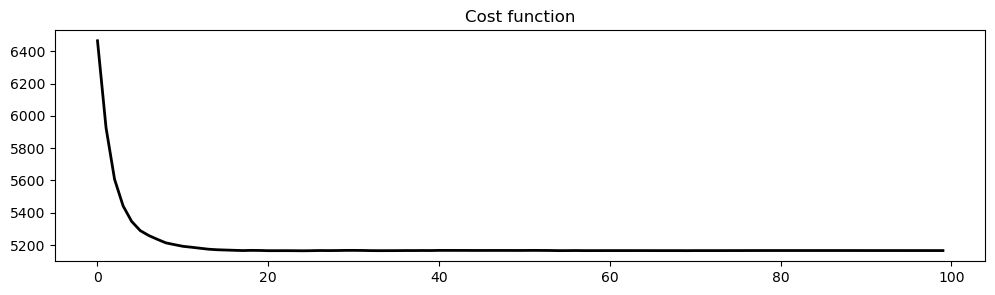

In [12]:
Op = Diagonal(mask.ravel())

igdata = Op * ig.ravel()  # type: ignore

# 修改：先实例化 FISTA 类，传入算子
solver = FISTA(Op * Wop.H)  # type: ignore

# 修改：调用 solve 方法传入数据和其他参数
# 注意：移除了 returninfo=True，因为 solve 默认返回 (x, niter, cost)
igfilled_wav, niter, cost = solver.solve(igdata, niter=100,
                                  #threshkind='soft', eps=1e1,
                                  threshkind='soft-percentile', perc=10,
                                  show=True)
igfilled = np.real((Wop.H * igfilled_wav).reshape(ny, nx))

plt.figure(figsize=(12, 3))
plt.plot(cost, 'k', lw=2)
plt.title('Cost function');

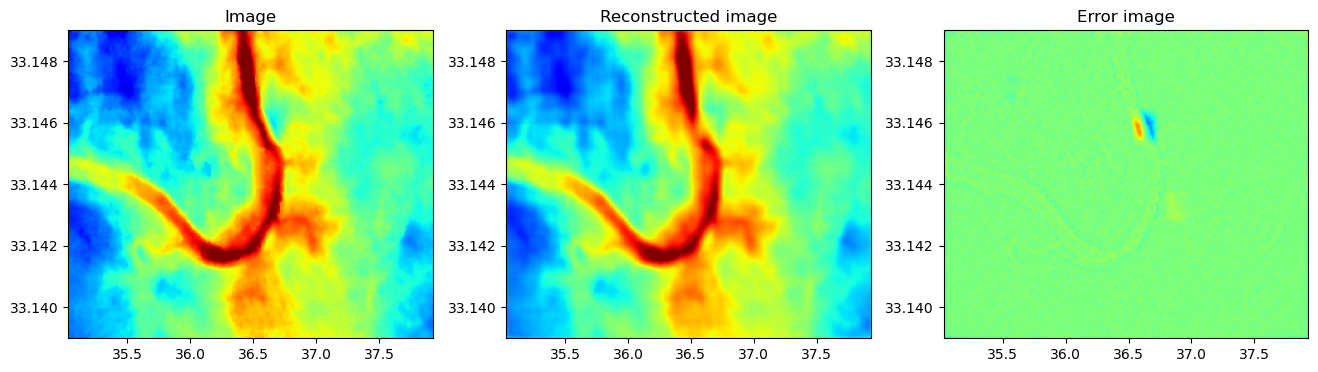

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(ig[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[0].set_title('Image')
axs[0].axis('tight')
axs[1].imshow(igfilled[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[1].set_title('Reconstructed image')
axs[1].axis('tight');
axs[2].imshow(ig[:nyorig, :nxorig]-igfilled[:nyorig, :nxorig], cmap='jet', vmin=-14, vmax=14,
              extent=(x[0], x[-1], y[0], y[1]), origin='lower')
axs[2].set_title('Error image')
axs[2].axis('tight');

In [14]:
scooby.Report(core='pylops')  # type: ignore

--------------------------------------------------------------------------------
  Date: Mon Dec 08 03:13:13 2025 UTC

                OS : Windows (10 10.0.19041 SP0 Multiprocessor Free)
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.1 GiB
       Environment : Jupyter

  Python 3.10.19 | packaged by conda-forge | (main, Oct 13 2025, 14:05:01)
  [MSC v.1944 64 bit (AMD64)]

            pylops : 2.6.0
             numpy : 2.2.6
             scipy : 1.15.3
           IPython : 8.37.0
        matplotlib : 3.10.6
            scooby : 0.10.2
--------------------------------------------------------------------------------

## 简单理解@Gemini 3 Pro

这个教程的核心任务叫 **“修复（Inpainting）”**，也就是**填补空洞**。

---

### 1. 我们的任务是什么？

想象你有一张**老照片**（或者是地下的地质层位图），但是这张照片被虫子咬了几个洞，或者被墨水弄脏了几块，导致有些地方的数据**丢失了**。

*   **原始数据 (`ig`)**：一张完整的、好看的图片。
*   **带空洞的数据 (`igholes`)**：这就是我们手里拿到的坏掉的图片，中间缺了几块（在代码里被设为了 0）。
*   **目标**：我们要当“修图师”，把这些空洞补回来，而且要补得自然，让人看不出是补过的。

### 2. 怎么补？（核心思想）

如果让你手动补，你会怎么做？你肯定会看空洞**周围**是什么样子的。
*   如果周围是平滑的渐变色，中间大概率也是渐变过去。
*   如果周围有纹理（比如波浪线），中间大概率也是连着的波浪线。

计算机也是这么想的，但它需要一个工具来描述这种“纹理”或“规律”。这个工具就是教程里提到的 **变换（Transform）**。

#### 关键概念：稀疏性 (Sparsity)

这是本教程最核心的魔法。

*   **在普通视角下（像素域）**：图片是很复杂的，每个点都有颜色，很难看出规律。
*   **在特殊视角下（变换域）**：图片其实很简单，只有少数几个“关键特征”在起作用。

**举个例子：**
想象一段音乐。
*   **普通视角**：是一堆乱七八糟的高低电平波动，很难描述。
*   **特殊视角（乐谱）**：其实就是几个音符（Do, Re, Mi）。虽然声音很复杂，但写成乐谱就很简单（稀疏）。

**在这个教程里：**
*   **DWT（小波变换）** 和 **FFT（傅里叶变换）** 就是那个“乐谱”。
*   我们假设：**完整的地质层位图，写成“乐谱”应该是很简单的（稀疏的）。**

### 3. 计算机是怎么“修图”的？（FISTA 算法）

计算机（FISTA 求解器）在做这样一道**填空题**：

> “请帮我找一张图片，它必须满足两个条件：
> 1.  **条件一**：这张图片在没破损的地方，必须和原图一模一样（不能瞎改原有的数据）。
> 2.  **条件二**：这张图片转换成‘乐谱’（变换域）后，音符要尽可能少（稀疏）。”

**为什么要“音符尽可能少”？**
因为噪音和乱填的数据通常很杂乱，对应的“音符”会非常多。而自然、平滑、有规律的图像，对应的“音符”很少。**强迫它“简单”，它就会自动把空洞填补成最平滑、最自然的形状。**

### 4. 教程流程总结

1.  **加载数据**：拿出一张完整的地质图。
2.  **挖洞**：故意把几个方块区域的数据删掉，模拟数据丢失。
3.  **方法一 (DWT)**：
    *   告诉计算机：这张图的规律像“小波”（一种特殊的波浪）。
    *   计算机开始算：怎么填这些洞，才能让整张图的小波系数最少？
    *   结果：洞补上了，效果还不错。
4.  **方法二 (FFT)**：
    *   告诉计算机：这张图的规律像“正弦波”（普通的波浪）。
    *   计算机重新算。
    *   结果：洞也补上了，你可以对比一下哪种方法补得更像原来的样子。

### 一句话总结

这个教程就是教你用 **PyLops** 这个工具，利用**“原本简单的东西应该保持简单”**（稀疏性）这个原理，自动把图片里缺失的部分**“脑补”**回来。